# Face Generation
In this project, I will use generative adversarial (GAN) networks to generate new images of faces.
### Get the Data
I'm using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex, I will be testing my neural network on MNIST before CelebA.  Running the GANs on MNIST will show us how well the model trains sooner.

If you're running this notebook using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

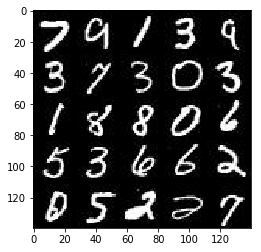

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

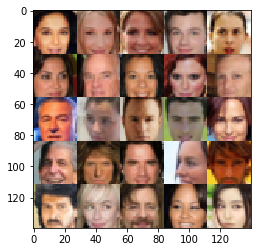

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
Here I will set up the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Here I implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Here I implement the `discriminator` function to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  I am using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Here I implement the `generator` function to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  I am using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Here I implement the `model_loss` function to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  I am using the discriminator and generator functions:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Here I implement the `model_opt` function to create the optimization operations for the GANs. I am using [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Then I filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Here I am using this function show_generator_output to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Here I implement the `train` function to build and train the GANs.  This is where we will use the model_inputs, model_loss, and model_opt functions already implemented above:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

We will also use the `show_generator_output` to show `generator` output while training. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Need to first map the input_real dims to data_shape
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    ### Build GAN
    
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out
                
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Here we can test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  We'll want to make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/1875:  Discriminator loss = 1.5097  Generator loss = 0.5125
Epoch 1/2 - Batch 20/1875:  Discriminator loss = 0.6248  Generator loss = 1.7948
Epoch 1/2 - Batch 30/1875:  Discriminator loss = 1.1965  Generator loss = 2.4052
Epoch 1/2 - Batch 40/1875:  Discriminator loss = 3.0964  Generator loss = 0.0927
Epoch 1/2 - Batch 50/1875:  Discriminator loss = 0.7379  Generator loss = 2.4874
Epoch 1/2 - Batch 60/1875:  Discriminator loss = 0.6264  Generator loss = 1.7219
Epoch 1/2 - Batch 70/1875:  Discriminator loss = 1.3634  Generator loss = 0.6259
Epoch 1/2 - Batch 80/1875:  Discriminator loss = 1.4969  Generator loss = 0.7578
Epoch 1/2 - Batch 90/1875:  Discriminator loss = 0.7809  Generator loss = 1.5334
Epoch 1/2 - Batch 100/1875:  Discriminator loss = 0.6782  Generator loss = 1.6896


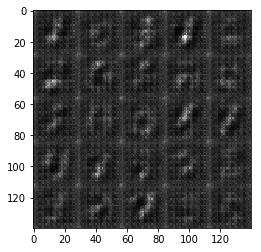

Epoch 1/2 - Batch 110/1875:  Discriminator loss = 0.7783  Generator loss = 1.6218
Epoch 1/2 - Batch 120/1875:  Discriminator loss = 1.1989  Generator loss = 0.7372
Epoch 1/2 - Batch 130/1875:  Discriminator loss = 0.7453  Generator loss = 1.7314
Epoch 1/2 - Batch 140/1875:  Discriminator loss = 1.5678  Generator loss = 3.5325
Epoch 1/2 - Batch 150/1875:  Discriminator loss = 1.1989  Generator loss = 0.6674
Epoch 1/2 - Batch 160/1875:  Discriminator loss = 1.4303  Generator loss = 0.5186
Epoch 1/2 - Batch 170/1875:  Discriminator loss = 0.7479  Generator loss = 1.2656
Epoch 1/2 - Batch 180/1875:  Discriminator loss = 0.7289  Generator loss = 2.1954
Epoch 1/2 - Batch 190/1875:  Discriminator loss = 0.8908  Generator loss = 1.0083
Epoch 1/2 - Batch 200/1875:  Discriminator loss = 0.6834  Generator loss = 1.9295


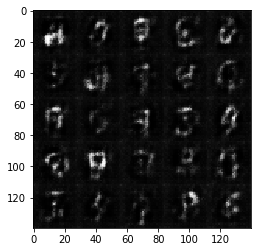

Epoch 1/2 - Batch 210/1875:  Discriminator loss = 1.2676  Generator loss = 3.6274
Epoch 1/2 - Batch 220/1875:  Discriminator loss = 1.0549  Generator loss = 0.7748
Epoch 1/2 - Batch 230/1875:  Discriminator loss = 0.6856  Generator loss = 1.9397
Epoch 1/2 - Batch 240/1875:  Discriminator loss = 0.6849  Generator loss = 1.6256
Epoch 1/2 - Batch 250/1875:  Discriminator loss = 0.7447  Generator loss = 1.2883
Epoch 1/2 - Batch 260/1875:  Discriminator loss = 0.7812  Generator loss = 1.1883
Epoch 1/2 - Batch 270/1875:  Discriminator loss = 0.6809  Generator loss = 3.1709
Epoch 1/2 - Batch 280/1875:  Discriminator loss = 0.6534  Generator loss = 1.7711
Epoch 1/2 - Batch 290/1875:  Discriminator loss = 0.7063  Generator loss = 2.1993
Epoch 1/2 - Batch 300/1875:  Discriminator loss = 0.7299  Generator loss = 1.2833


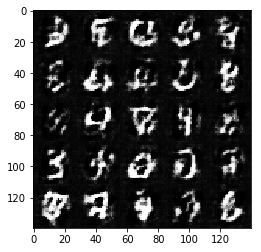

Epoch 1/2 - Batch 310/1875:  Discriminator loss = 0.6698  Generator loss = 1.6343
Epoch 1/2 - Batch 320/1875:  Discriminator loss = 0.6301  Generator loss = 1.8796
Epoch 1/2 - Batch 330/1875:  Discriminator loss = 0.7721  Generator loss = 1.2163
Epoch 1/2 - Batch 340/1875:  Discriminator loss = 0.5863  Generator loss = 1.9510
Epoch 1/2 - Batch 350/1875:  Discriminator loss = 0.6753  Generator loss = 3.0281
Epoch 1/2 - Batch 360/1875:  Discriminator loss = 0.8096  Generator loss = 1.1193
Epoch 1/2 - Batch 370/1875:  Discriminator loss = 0.6164  Generator loss = 1.7219
Epoch 1/2 - Batch 380/1875:  Discriminator loss = 0.7172  Generator loss = 1.9626
Epoch 1/2 - Batch 390/1875:  Discriminator loss = 0.6671  Generator loss = 1.7333
Epoch 1/2 - Batch 400/1875:  Discriminator loss = 0.8267  Generator loss = 1.0989


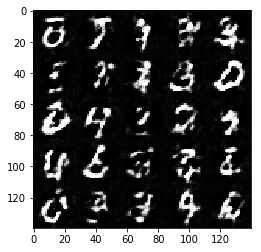

Epoch 1/2 - Batch 410/1875:  Discriminator loss = 0.8603  Generator loss = 1.6107
Epoch 1/2 - Batch 420/1875:  Discriminator loss = 0.9630  Generator loss = 0.9993
Epoch 1/2 - Batch 430/1875:  Discriminator loss = 0.6788  Generator loss = 1.7949
Epoch 1/2 - Batch 440/1875:  Discriminator loss = 0.6364  Generator loss = 1.9600
Epoch 1/2 - Batch 450/1875:  Discriminator loss = 0.6990  Generator loss = 2.3660
Epoch 1/2 - Batch 460/1875:  Discriminator loss = 0.7120  Generator loss = 2.1802
Epoch 1/2 - Batch 470/1875:  Discriminator loss = 1.5334  Generator loss = 0.4891
Epoch 1/2 - Batch 480/1875:  Discriminator loss = 0.7220  Generator loss = 2.3775
Epoch 1/2 - Batch 490/1875:  Discriminator loss = 0.5863  Generator loss = 1.8830
Epoch 1/2 - Batch 500/1875:  Discriminator loss = 0.7168  Generator loss = 1.4699


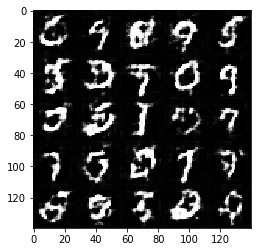

Epoch 1/2 - Batch 510/1875:  Discriminator loss = 0.6473  Generator loss = 2.3198
Epoch 1/2 - Batch 520/1875:  Discriminator loss = 0.7300  Generator loss = 1.4174
Epoch 1/2 - Batch 530/1875:  Discriminator loss = 0.9956  Generator loss = 1.0573
Epoch 1/2 - Batch 540/1875:  Discriminator loss = 0.6581  Generator loss = 1.8352
Epoch 1/2 - Batch 550/1875:  Discriminator loss = 0.6539  Generator loss = 1.6329
Epoch 1/2 - Batch 560/1875:  Discriminator loss = 0.7468  Generator loss = 2.2903
Epoch 1/2 - Batch 570/1875:  Discriminator loss = 0.6741  Generator loss = 1.4568
Epoch 1/2 - Batch 580/1875:  Discriminator loss = 0.7081  Generator loss = 1.4345
Epoch 1/2 - Batch 590/1875:  Discriminator loss = 0.7107  Generator loss = 1.3791
Epoch 1/2 - Batch 600/1875:  Discriminator loss = 0.6861  Generator loss = 1.3941


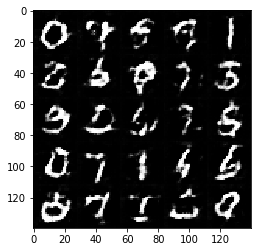

Epoch 1/2 - Batch 610/1875:  Discriminator loss = 0.5864  Generator loss = 1.9236
Epoch 1/2 - Batch 620/1875:  Discriminator loss = 0.7469  Generator loss = 2.9900
Epoch 1/2 - Batch 630/1875:  Discriminator loss = 0.7857  Generator loss = 1.1671
Epoch 1/2 - Batch 640/1875:  Discriminator loss = 0.6411  Generator loss = 2.2791
Epoch 1/2 - Batch 650/1875:  Discriminator loss = 0.9968  Generator loss = 1.1519
Epoch 1/2 - Batch 660/1875:  Discriminator loss = 0.8965  Generator loss = 1.0049
Epoch 1/2 - Batch 670/1875:  Discriminator loss = 1.0848  Generator loss = 0.9079
Epoch 1/2 - Batch 680/1875:  Discriminator loss = 0.7741  Generator loss = 1.4938
Epoch 1/2 - Batch 690/1875:  Discriminator loss = 0.7737  Generator loss = 1.2345
Epoch 1/2 - Batch 700/1875:  Discriminator loss = 0.8474  Generator loss = 1.0605


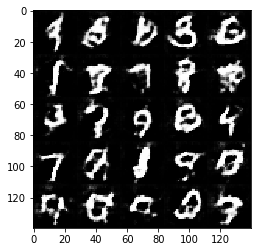

Epoch 1/2 - Batch 710/1875:  Discriminator loss = 0.7113  Generator loss = 1.4576
Epoch 1/2 - Batch 720/1875:  Discriminator loss = 1.0381  Generator loss = 0.8502
Epoch 1/2 - Batch 730/1875:  Discriminator loss = 0.6512  Generator loss = 1.6591
Epoch 1/2 - Batch 740/1875:  Discriminator loss = 0.7742  Generator loss = 1.2133
Epoch 1/2 - Batch 750/1875:  Discriminator loss = 1.3201  Generator loss = 0.5959
Epoch 1/2 - Batch 760/1875:  Discriminator loss = 1.4531  Generator loss = 0.4971
Epoch 1/2 - Batch 770/1875:  Discriminator loss = 0.8396  Generator loss = 2.0099
Epoch 1/2 - Batch 780/1875:  Discriminator loss = 0.9206  Generator loss = 0.9847
Epoch 1/2 - Batch 790/1875:  Discriminator loss = 1.3257  Generator loss = 2.7010
Epoch 1/2 - Batch 800/1875:  Discriminator loss = 1.2296  Generator loss = 3.2887


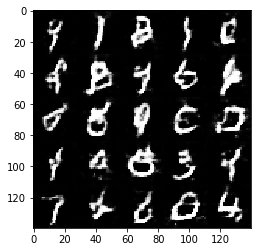

Epoch 1/2 - Batch 810/1875:  Discriminator loss = 1.0233  Generator loss = 1.2087
Epoch 1/2 - Batch 820/1875:  Discriminator loss = 0.8208  Generator loss = 1.2445
Epoch 1/2 - Batch 830/1875:  Discriminator loss = 1.0588  Generator loss = 0.9652
Epoch 1/2 - Batch 840/1875:  Discriminator loss = 0.8807  Generator loss = 1.1577
Epoch 1/2 - Batch 850/1875:  Discriminator loss = 1.1644  Generator loss = 0.6913
Epoch 1/2 - Batch 860/1875:  Discriminator loss = 0.9386  Generator loss = 0.9083
Epoch 1/2 - Batch 870/1875:  Discriminator loss = 0.6749  Generator loss = 1.9949
Epoch 1/2 - Batch 880/1875:  Discriminator loss = 0.7720  Generator loss = 1.2667
Epoch 1/2 - Batch 890/1875:  Discriminator loss = 0.5964  Generator loss = 2.1338
Epoch 1/2 - Batch 900/1875:  Discriminator loss = 1.1109  Generator loss = 0.7337


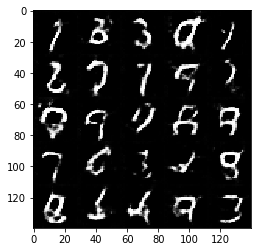

Epoch 1/2 - Batch 910/1875:  Discriminator loss = 0.6282  Generator loss = 1.7508
Epoch 1/2 - Batch 920/1875:  Discriminator loss = 0.6279  Generator loss = 1.5629
Epoch 1/2 - Batch 930/1875:  Discriminator loss = 1.2452  Generator loss = 0.6975
Epoch 1/2 - Batch 940/1875:  Discriminator loss = 0.7428  Generator loss = 1.2236
Epoch 1/2 - Batch 950/1875:  Discriminator loss = 2.3828  Generator loss = 0.2407
Epoch 1/2 - Batch 960/1875:  Discriminator loss = 0.8213  Generator loss = 1.1884
Epoch 1/2 - Batch 970/1875:  Discriminator loss = 1.2057  Generator loss = 0.6857
Epoch 1/2 - Batch 980/1875:  Discriminator loss = 0.7811  Generator loss = 1.2042
Epoch 1/2 - Batch 990/1875:  Discriminator loss = 0.9505  Generator loss = 0.9398
Epoch 1/2 - Batch 1000/1875:  Discriminator loss = 0.8845  Generator loss = 0.9756


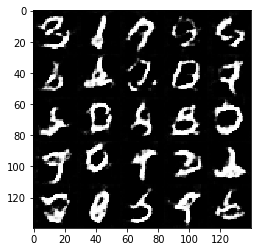

Epoch 1/2 - Batch 1010/1875:  Discriminator loss = 0.8538  Generator loss = 1.1734
Epoch 1/2 - Batch 1020/1875:  Discriminator loss = 0.8197  Generator loss = 1.1564
Epoch 1/2 - Batch 1030/1875:  Discriminator loss = 0.8400  Generator loss = 1.4455
Epoch 1/2 - Batch 1040/1875:  Discriminator loss = 1.4133  Generator loss = 0.5398
Epoch 1/2 - Batch 1050/1875:  Discriminator loss = 0.9023  Generator loss = 1.8897
Epoch 1/2 - Batch 1060/1875:  Discriminator loss = 1.3546  Generator loss = 0.5475
Epoch 1/2 - Batch 1070/1875:  Discriminator loss = 0.9279  Generator loss = 0.9782
Epoch 1/2 - Batch 1080/1875:  Discriminator loss = 0.7192  Generator loss = 1.9156
Epoch 1/2 - Batch 1090/1875:  Discriminator loss = 0.9640  Generator loss = 0.9622
Epoch 1/2 - Batch 1100/1875:  Discriminator loss = 0.8781  Generator loss = 0.9561


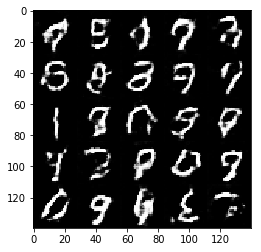

Epoch 1/2 - Batch 1110/1875:  Discriminator loss = 1.0025  Generator loss = 0.8061
Epoch 1/2 - Batch 1120/1875:  Discriminator loss = 1.9607  Generator loss = 0.3533
Epoch 1/2 - Batch 1130/1875:  Discriminator loss = 1.3051  Generator loss = 0.5770
Epoch 1/2 - Batch 1140/1875:  Discriminator loss = 1.1790  Generator loss = 0.6637
Epoch 1/2 - Batch 1150/1875:  Discriminator loss = 0.9218  Generator loss = 0.9098
Epoch 1/2 - Batch 1160/1875:  Discriminator loss = 1.2705  Generator loss = 0.6393
Epoch 1/2 - Batch 1170/1875:  Discriminator loss = 0.8309  Generator loss = 1.2363
Epoch 1/2 - Batch 1180/1875:  Discriminator loss = 0.8865  Generator loss = 0.9845
Epoch 1/2 - Batch 1190/1875:  Discriminator loss = 1.5933  Generator loss = 0.5436
Epoch 1/2 - Batch 1200/1875:  Discriminator loss = 0.9742  Generator loss = 0.8703


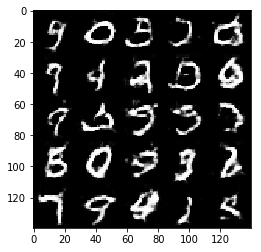

Epoch 1/2 - Batch 1210/1875:  Discriminator loss = 0.7499  Generator loss = 1.8437
Epoch 1/2 - Batch 1220/1875:  Discriminator loss = 1.1145  Generator loss = 0.6921
Epoch 1/2 - Batch 1230/1875:  Discriminator loss = 0.6697  Generator loss = 1.5001
Epoch 1/2 - Batch 1240/1875:  Discriminator loss = 0.6766  Generator loss = 1.4706
Epoch 1/2 - Batch 1250/1875:  Discriminator loss = 0.6941  Generator loss = 1.3589
Epoch 1/2 - Batch 1260/1875:  Discriminator loss = 1.1429  Generator loss = 0.6844
Epoch 1/2 - Batch 1270/1875:  Discriminator loss = 0.5895  Generator loss = 1.6902
Epoch 1/2 - Batch 1280/1875:  Discriminator loss = 0.5942  Generator loss = 2.2923
Epoch 1/2 - Batch 1290/1875:  Discriminator loss = 1.2756  Generator loss = 2.7252
Epoch 1/2 - Batch 1300/1875:  Discriminator loss = 0.7857  Generator loss = 2.7765


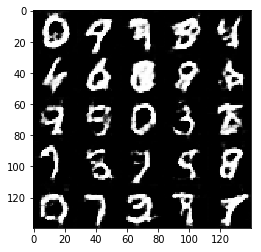

Epoch 1/2 - Batch 1310/1875:  Discriminator loss = 0.7207  Generator loss = 1.3853
Epoch 1/2 - Batch 1320/1875:  Discriminator loss = 0.7915  Generator loss = 2.4865
Epoch 1/2 - Batch 1330/1875:  Discriminator loss = 0.9528  Generator loss = 0.9422
Epoch 1/2 - Batch 1340/1875:  Discriminator loss = 0.7465  Generator loss = 1.2825
Epoch 1/2 - Batch 1350/1875:  Discriminator loss = 1.0359  Generator loss = 0.8459
Epoch 1/2 - Batch 1360/1875:  Discriminator loss = 0.8341  Generator loss = 1.0615
Epoch 1/2 - Batch 1370/1875:  Discriminator loss = 1.3102  Generator loss = 0.6218
Epoch 1/2 - Batch 1380/1875:  Discriminator loss = 0.6430  Generator loss = 1.5801
Epoch 1/2 - Batch 1390/1875:  Discriminator loss = 1.1143  Generator loss = 0.7474
Epoch 1/2 - Batch 1400/1875:  Discriminator loss = 0.7578  Generator loss = 1.4456


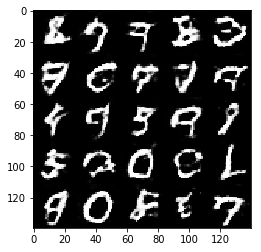

Epoch 1/2 - Batch 1410/1875:  Discriminator loss = 0.7406  Generator loss = 1.2766
Epoch 1/2 - Batch 1420/1875:  Discriminator loss = 0.7925  Generator loss = 1.1683
Epoch 1/2 - Batch 1430/1875:  Discriminator loss = 0.7519  Generator loss = 1.1543
Epoch 1/2 - Batch 1440/1875:  Discriminator loss = 1.1020  Generator loss = 0.6948
Epoch 1/2 - Batch 1450/1875:  Discriminator loss = 0.7126  Generator loss = 1.3000
Epoch 1/2 - Batch 1460/1875:  Discriminator loss = 5.0542  Generator loss = 8.2998
Epoch 1/2 - Batch 1470/1875:  Discriminator loss = 1.1054  Generator loss = 0.7774
Epoch 1/2 - Batch 1480/1875:  Discriminator loss = 1.0310  Generator loss = 0.8655
Epoch 1/2 - Batch 1490/1875:  Discriminator loss = 1.0626  Generator loss = 0.8204
Epoch 1/2 - Batch 1500/1875:  Discriminator loss = 0.6993  Generator loss = 1.4239


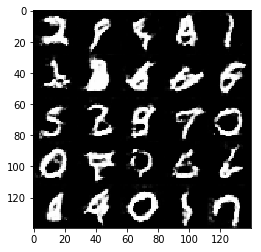

Epoch 1/2 - Batch 1510/1875:  Discriminator loss = 1.0109  Generator loss = 2.7687
Epoch 1/2 - Batch 1520/1875:  Discriminator loss = 0.9431  Generator loss = 0.9744
Epoch 1/2 - Batch 1530/1875:  Discriminator loss = 0.7462  Generator loss = 1.2459
Epoch 1/2 - Batch 1540/1875:  Discriminator loss = 0.7619  Generator loss = 1.2336
Epoch 1/2 - Batch 1550/1875:  Discriminator loss = 0.7858  Generator loss = 1.3836
Epoch 1/2 - Batch 1560/1875:  Discriminator loss = 0.6269  Generator loss = 1.5408
Epoch 1/2 - Batch 1570/1875:  Discriminator loss = 0.5756  Generator loss = 1.8064
Epoch 1/2 - Batch 1580/1875:  Discriminator loss = 0.9166  Generator loss = 2.1410
Epoch 1/2 - Batch 1590/1875:  Discriminator loss = 0.7239  Generator loss = 1.9806
Epoch 1/2 - Batch 1600/1875:  Discriminator loss = 0.9726  Generator loss = 0.9219


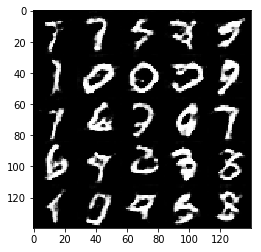

Epoch 1/2 - Batch 1610/1875:  Discriminator loss = 0.6880  Generator loss = 1.5185
Epoch 1/2 - Batch 1620/1875:  Discriminator loss = 0.7042  Generator loss = 1.3573
Epoch 1/2 - Batch 1630/1875:  Discriminator loss = 0.5478  Generator loss = 1.9941
Epoch 1/2 - Batch 1640/1875:  Discriminator loss = 0.5345  Generator loss = 2.0102
Epoch 1/2 - Batch 1650/1875:  Discriminator loss = 1.0599  Generator loss = 0.9643
Epoch 1/2 - Batch 1660/1875:  Discriminator loss = 0.6271  Generator loss = 1.9472
Epoch 1/2 - Batch 1670/1875:  Discriminator loss = 1.6050  Generator loss = 3.0312
Epoch 1/2 - Batch 1680/1875:  Discriminator loss = 0.7607  Generator loss = 1.4796
Epoch 1/2 - Batch 1690/1875:  Discriminator loss = 1.0087  Generator loss = 0.8657
Epoch 1/2 - Batch 1700/1875:  Discriminator loss = 0.8987  Generator loss = 0.9574


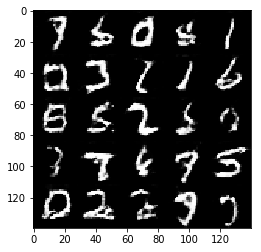

Epoch 1/2 - Batch 1710/1875:  Discriminator loss = 0.9599  Generator loss = 0.9513
Epoch 1/2 - Batch 1720/1875:  Discriminator loss = 1.0065  Generator loss = 0.9077
Epoch 1/2 - Batch 1730/1875:  Discriminator loss = 0.5871  Generator loss = 1.9946
Epoch 1/2 - Batch 1740/1875:  Discriminator loss = 1.2149  Generator loss = 0.6525
Epoch 1/2 - Batch 1750/1875:  Discriminator loss = 1.2799  Generator loss = 0.6343
Epoch 1/2 - Batch 1760/1875:  Discriminator loss = 1.6420  Generator loss = 0.4916
Epoch 1/2 - Batch 1770/1875:  Discriminator loss = 0.7581  Generator loss = 1.3109
Epoch 1/2 - Batch 1780/1875:  Discriminator loss = 0.7552  Generator loss = 1.3477
Epoch 1/2 - Batch 1790/1875:  Discriminator loss = 0.7480  Generator loss = 1.2670
Epoch 1/2 - Batch 1800/1875:  Discriminator loss = 0.9715  Generator loss = 0.9235


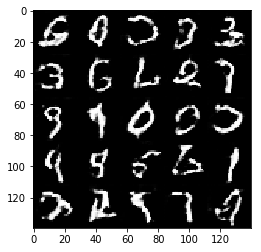

Epoch 1/2 - Batch 1810/1875:  Discriminator loss = 0.5524  Generator loss = 2.1013
Epoch 1/2 - Batch 1820/1875:  Discriminator loss = 1.2784  Generator loss = 0.7486
Epoch 1/2 - Batch 1830/1875:  Discriminator loss = 0.6627  Generator loss = 1.6500
Epoch 1/2 - Batch 1840/1875:  Discriminator loss = 0.6979  Generator loss = 1.4498
Epoch 1/2 - Batch 1850/1875:  Discriminator loss = 0.7238  Generator loss = 1.8715
Epoch 1/2 - Batch 1860/1875:  Discriminator loss = 1.1429  Generator loss = 0.7155
Epoch 1/2 - Batch 1870/1875:  Discriminator loss = 0.8201  Generator loss = 1.2611
Epoch 2/2 - Batch 10/1875:  Discriminator loss = 0.8416  Generator loss = 1.1375
Epoch 2/2 - Batch 20/1875:  Discriminator loss = 0.8638  Generator loss = 1.1165
Epoch 2/2 - Batch 30/1875:  Discriminator loss = 0.9478  Generator loss = 0.9005
Epoch 2/2 - Batch 40/1875:  Discriminator loss = 0.7246  Generator loss = 1.3382
Epoch 2/2 - Batch 50/1875:  Discriminator loss = 0.8212  Generator loss = 1.0936
Epoch 2/2 - Ba

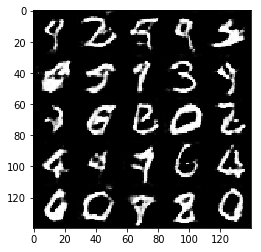

Epoch 2/2 - Batch 110/1875:  Discriminator loss = 1.3456  Generator loss = 3.1334
Epoch 2/2 - Batch 120/1875:  Discriminator loss = 0.5948  Generator loss = 2.3814
Epoch 2/2 - Batch 130/1875:  Discriminator loss = 1.2218  Generator loss = 0.6500
Epoch 2/2 - Batch 140/1875:  Discriminator loss = 0.8754  Generator loss = 1.9538
Epoch 2/2 - Batch 150/1875:  Discriminator loss = 0.6549  Generator loss = 1.5489
Epoch 2/2 - Batch 160/1875:  Discriminator loss = 0.5946  Generator loss = 1.7098
Epoch 2/2 - Batch 170/1875:  Discriminator loss = 0.9054  Generator loss = 0.9865
Epoch 2/2 - Batch 180/1875:  Discriminator loss = 0.8044  Generator loss = 1.8660
Epoch 2/2 - Batch 190/1875:  Discriminator loss = 0.6337  Generator loss = 2.0585
Epoch 2/2 - Batch 200/1875:  Discriminator loss = 0.7649  Generator loss = 1.3224


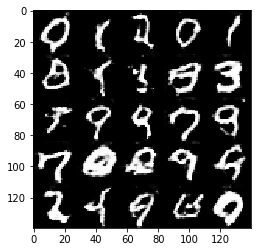

Epoch 2/2 - Batch 210/1875:  Discriminator loss = 0.7828  Generator loss = 1.1375
Epoch 2/2 - Batch 220/1875:  Discriminator loss = 0.6151  Generator loss = 1.7183
Epoch 2/2 - Batch 230/1875:  Discriminator loss = 1.1949  Generator loss = 0.6600
Epoch 2/2 - Batch 240/1875:  Discriminator loss = 1.3755  Generator loss = 0.6559
Epoch 2/2 - Batch 250/1875:  Discriminator loss = 0.6900  Generator loss = 1.7189
Epoch 2/2 - Batch 260/1875:  Discriminator loss = 0.9939  Generator loss = 0.8837
Epoch 2/2 - Batch 270/1875:  Discriminator loss = 0.7653  Generator loss = 1.2603
Epoch 2/2 - Batch 280/1875:  Discriminator loss = 0.9233  Generator loss = 1.0167
Epoch 2/2 - Batch 290/1875:  Discriminator loss = 1.0690  Generator loss = 0.8292
Epoch 2/2 - Batch 300/1875:  Discriminator loss = 0.9308  Generator loss = 0.9147


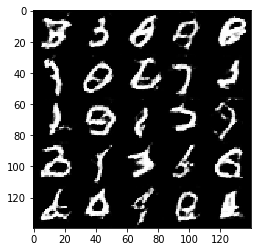

Epoch 2/2 - Batch 310/1875:  Discriminator loss = 1.3898  Generator loss = 0.5700
Epoch 2/2 - Batch 320/1875:  Discriminator loss = 1.1081  Generator loss = 0.7672
Epoch 2/2 - Batch 330/1875:  Discriminator loss = 0.8010  Generator loss = 1.2735
Epoch 2/2 - Batch 340/1875:  Discriminator loss = 0.6663  Generator loss = 1.5584
Epoch 2/2 - Batch 350/1875:  Discriminator loss = 1.1881  Generator loss = 3.1939
Epoch 2/2 - Batch 360/1875:  Discriminator loss = 0.7588  Generator loss = 2.8240
Epoch 2/2 - Batch 370/1875:  Discriminator loss = 0.5564  Generator loss = 2.0336
Epoch 2/2 - Batch 380/1875:  Discriminator loss = 0.8034  Generator loss = 1.2445
Epoch 2/2 - Batch 390/1875:  Discriminator loss = 0.5394  Generator loss = 1.9962
Epoch 2/2 - Batch 400/1875:  Discriminator loss = 0.7662  Generator loss = 1.2562


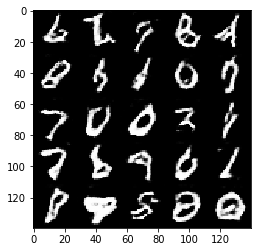

Epoch 2/2 - Batch 410/1875:  Discriminator loss = 2.1476  Generator loss = 4.9562
Epoch 2/2 - Batch 420/1875:  Discriminator loss = 1.5953  Generator loss = 0.4874
Epoch 2/2 - Batch 430/1875:  Discriminator loss = 0.7164  Generator loss = 1.4067
Epoch 2/2 - Batch 440/1875:  Discriminator loss = 0.6632  Generator loss = 1.8011
Epoch 2/2 - Batch 450/1875:  Discriminator loss = 1.5652  Generator loss = 0.4961
Epoch 2/2 - Batch 460/1875:  Discriminator loss = 0.5747  Generator loss = 1.9454
Epoch 2/2 - Batch 470/1875:  Discriminator loss = 1.6354  Generator loss = 0.4222
Epoch 2/2 - Batch 480/1875:  Discriminator loss = 0.8743  Generator loss = 1.0848
Epoch 2/2 - Batch 500/1875:  Discriminator loss = 0.7706  Generator loss = 1.3276


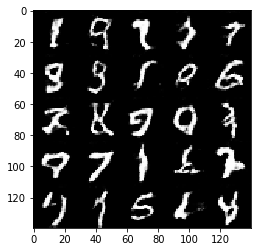

Epoch 2/2 - Batch 510/1875:  Discriminator loss = 0.5643  Generator loss = 2.2276
Epoch 2/2 - Batch 520/1875:  Discriminator loss = 0.6733  Generator loss = 2.0506
Epoch 2/2 - Batch 530/1875:  Discriminator loss = 0.6547  Generator loss = 1.5679
Epoch 2/2 - Batch 540/1875:  Discriminator loss = 0.8384  Generator loss = 1.1013
Epoch 2/2 - Batch 550/1875:  Discriminator loss = 0.7425  Generator loss = 1.2833
Epoch 2/2 - Batch 560/1875:  Discriminator loss = 0.4720  Generator loss = 2.2789
Epoch 2/2 - Batch 570/1875:  Discriminator loss = 0.6806  Generator loss = 1.4816
Epoch 2/2 - Batch 580/1875:  Discriminator loss = 0.6079  Generator loss = 1.6827
Epoch 2/2 - Batch 590/1875:  Discriminator loss = 0.6561  Generator loss = 1.8876
Epoch 2/2 - Batch 600/1875:  Discriminator loss = 0.5262  Generator loss = 2.1203


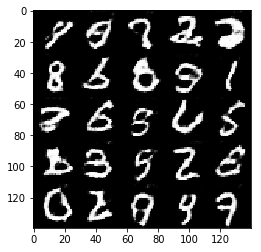

Epoch 2/2 - Batch 610/1875:  Discriminator loss = 0.6502  Generator loss = 1.5208
Epoch 2/2 - Batch 620/1875:  Discriminator loss = 1.1642  Generator loss = 0.8844
Epoch 2/2 - Batch 630/1875:  Discriminator loss = 1.4267  Generator loss = 0.5432
Epoch 2/2 - Batch 640/1875:  Discriminator loss = 0.8513  Generator loss = 1.1184
Epoch 2/2 - Batch 650/1875:  Discriminator loss = 0.7188  Generator loss = 1.3614
Epoch 2/2 - Batch 660/1875:  Discriminator loss = 0.6541  Generator loss = 1.4888
Epoch 2/2 - Batch 670/1875:  Discriminator loss = 0.6418  Generator loss = 1.7695
Epoch 2/2 - Batch 680/1875:  Discriminator loss = 0.6587  Generator loss = 1.7786
Epoch 2/2 - Batch 690/1875:  Discriminator loss = 0.6369  Generator loss = 1.9618
Epoch 2/2 - Batch 700/1875:  Discriminator loss = 0.6145  Generator loss = 1.6825


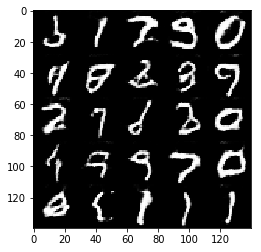

Epoch 2/2 - Batch 710/1875:  Discriminator loss = 0.5992  Generator loss = 2.1776
Epoch 2/2 - Batch 720/1875:  Discriminator loss = 0.7841  Generator loss = 1.2451
Epoch 2/2 - Batch 730/1875:  Discriminator loss = 0.5854  Generator loss = 1.7555
Epoch 2/2 - Batch 740/1875:  Discriminator loss = 0.6694  Generator loss = 1.4371
Epoch 2/2 - Batch 750/1875:  Discriminator loss = 3.2873  Generator loss = 0.1337
Epoch 2/2 - Batch 760/1875:  Discriminator loss = 0.6544  Generator loss = 2.2331
Epoch 2/2 - Batch 770/1875:  Discriminator loss = 0.6185  Generator loss = 1.9538
Epoch 2/2 - Batch 780/1875:  Discriminator loss = 1.0179  Generator loss = 0.8273
Epoch 2/2 - Batch 790/1875:  Discriminator loss = 0.7597  Generator loss = 1.4155
Epoch 2/2 - Batch 800/1875:  Discriminator loss = 0.7402  Generator loss = 2.3531


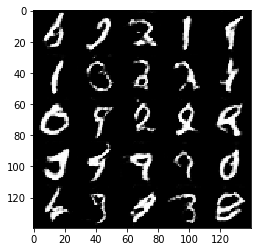

Epoch 2/2 - Batch 810/1875:  Discriminator loss = 0.5299  Generator loss = 2.0575
Epoch 2/2 - Batch 820/1875:  Discriminator loss = 0.5247  Generator loss = 2.1314
Epoch 2/2 - Batch 830/1875:  Discriminator loss = 0.8329  Generator loss = 1.3299
Epoch 2/2 - Batch 840/1875:  Discriminator loss = 0.5621  Generator loss = 2.0297
Epoch 2/2 - Batch 850/1875:  Discriminator loss = 0.5424  Generator loss = 2.0607
Epoch 2/2 - Batch 860/1875:  Discriminator loss = 0.6330  Generator loss = 1.9581
Epoch 2/2 - Batch 870/1875:  Discriminator loss = 0.5686  Generator loss = 2.6696
Epoch 2/2 - Batch 880/1875:  Discriminator loss = 0.8719  Generator loss = 1.1356
Epoch 2/2 - Batch 890/1875:  Discriminator loss = 0.8114  Generator loss = 2.3080
Epoch 2/2 - Batch 900/1875:  Discriminator loss = 0.7169  Generator loss = 1.4180


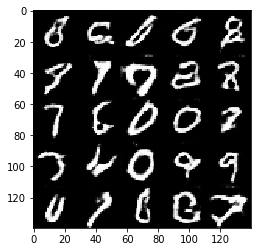

Epoch 2/2 - Batch 910/1875:  Discriminator loss = 0.8242  Generator loss = 1.0980
Epoch 2/2 - Batch 920/1875:  Discriminator loss = 0.6498  Generator loss = 1.8355
Epoch 2/2 - Batch 930/1875:  Discriminator loss = 0.9816  Generator loss = 0.8863
Epoch 2/2 - Batch 940/1875:  Discriminator loss = 0.7660  Generator loss = 1.2635
Epoch 2/2 - Batch 950/1875:  Discriminator loss = 1.1058  Generator loss = 0.6937
Epoch 2/2 - Batch 960/1875:  Discriminator loss = 0.7944  Generator loss = 1.2365
Epoch 2/2 - Batch 970/1875:  Discriminator loss = 0.7580  Generator loss = 1.2375
Epoch 2/2 - Batch 980/1875:  Discriminator loss = 2.5582  Generator loss = 5.6862
Epoch 2/2 - Batch 990/1875:  Discriminator loss = 1.4218  Generator loss = 0.5836
Epoch 2/2 - Batch 1000/1875:  Discriminator loss = 0.8928  Generator loss = 1.1575


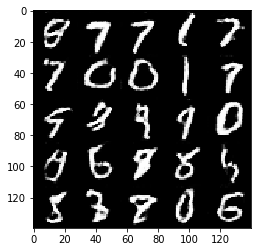

Epoch 2/2 - Batch 1010/1875:  Discriminator loss = 0.5880  Generator loss = 1.8029
Epoch 2/2 - Batch 1020/1875:  Discriminator loss = 0.5416  Generator loss = 1.9165
Epoch 2/2 - Batch 1030/1875:  Discriminator loss = 0.7291  Generator loss = 2.0354
Epoch 2/2 - Batch 1040/1875:  Discriminator loss = 0.6358  Generator loss = 2.6450
Epoch 2/2 - Batch 1050/1875:  Discriminator loss = 1.1048  Generator loss = 0.8769
Epoch 2/2 - Batch 1060/1875:  Discriminator loss = 0.8530  Generator loss = 1.0757
Epoch 2/2 - Batch 1070/1875:  Discriminator loss = 0.7626  Generator loss = 1.3233
Epoch 2/2 - Batch 1080/1875:  Discriminator loss = 1.2405  Generator loss = 0.6268
Epoch 2/2 - Batch 1090/1875:  Discriminator loss = 0.6783  Generator loss = 1.4370
Epoch 2/2 - Batch 1100/1875:  Discriminator loss = 0.8535  Generator loss = 3.0861


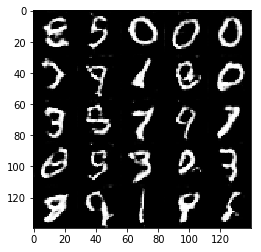

Epoch 2/2 - Batch 1110/1875:  Discriminator loss = 1.6362  Generator loss = 0.5959
Epoch 2/2 - Batch 1120/1875:  Discriminator loss = 0.6882  Generator loss = 2.8664
Epoch 2/2 - Batch 1130/1875:  Discriminator loss = 0.6147  Generator loss = 1.9150
Epoch 2/2 - Batch 1140/1875:  Discriminator loss = 0.5549  Generator loss = 1.9374
Epoch 2/2 - Batch 1150/1875:  Discriminator loss = 0.5990  Generator loss = 1.6416
Epoch 2/2 - Batch 1160/1875:  Discriminator loss = 0.8508  Generator loss = 1.0962
Epoch 2/2 - Batch 1170/1875:  Discriminator loss = 0.7090  Generator loss = 1.4084
Epoch 2/2 - Batch 1180/1875:  Discriminator loss = 0.6835  Generator loss = 1.4570
Epoch 2/2 - Batch 1190/1875:  Discriminator loss = 0.4830  Generator loss = 2.3030
Epoch 2/2 - Batch 1200/1875:  Discriminator loss = 1.4199  Generator loss = 0.8341


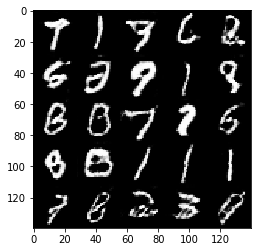

Epoch 2/2 - Batch 1210/1875:  Discriminator loss = 0.7881  Generator loss = 2.4883
Epoch 2/2 - Batch 1220/1875:  Discriminator loss = 1.4626  Generator loss = 0.5885
Epoch 2/2 - Batch 1230/1875:  Discriminator loss = 0.7077  Generator loss = 1.3202
Epoch 2/2 - Batch 1240/1875:  Discriminator loss = 0.6097  Generator loss = 1.7640
Epoch 2/2 - Batch 1250/1875:  Discriminator loss = 0.7620  Generator loss = 1.2084
Epoch 2/2 - Batch 1260/1875:  Discriminator loss = 0.5454  Generator loss = 1.9424
Epoch 2/2 - Batch 1270/1875:  Discriminator loss = 0.5562  Generator loss = 2.0617
Epoch 2/2 - Batch 1280/1875:  Discriminator loss = 0.5308  Generator loss = 2.2264
Epoch 2/2 - Batch 1290/1875:  Discriminator loss = 0.9661  Generator loss = 0.9223
Epoch 2/2 - Batch 1300/1875:  Discriminator loss = 0.6190  Generator loss = 1.6825


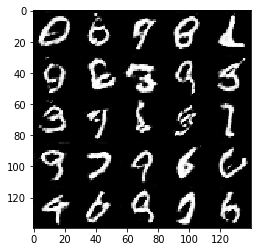

Epoch 2/2 - Batch 1310/1875:  Discriminator loss = 1.0166  Generator loss = 1.3975
Epoch 2/2 - Batch 1320/1875:  Discriminator loss = 0.9509  Generator loss = 2.9912
Epoch 2/2 - Batch 1330/1875:  Discriminator loss = 0.8154  Generator loss = 1.2758
Epoch 2/2 - Batch 1340/1875:  Discriminator loss = 0.9730  Generator loss = 1.0223
Epoch 2/2 - Batch 1350/1875:  Discriminator loss = 0.8318  Generator loss = 1.2471
Epoch 2/2 - Batch 1360/1875:  Discriminator loss = 0.6645  Generator loss = 1.6639
Epoch 2/2 - Batch 1370/1875:  Discriminator loss = 0.6380  Generator loss = 1.6000
Epoch 2/2 - Batch 1380/1875:  Discriminator loss = 0.6378  Generator loss = 1.7420
Epoch 2/2 - Batch 1390/1875:  Discriminator loss = 0.7536  Generator loss = 1.3367
Epoch 2/2 - Batch 1400/1875:  Discriminator loss = 0.6715  Generator loss = 1.5029


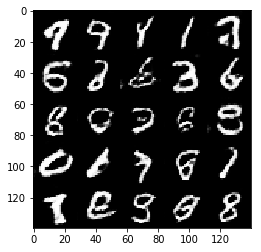

Epoch 2/2 - Batch 1410/1875:  Discriminator loss = 1.2200  Generator loss = 0.7545
Epoch 2/2 - Batch 1420/1875:  Discriminator loss = 0.5190  Generator loss = 2.1797
Epoch 2/2 - Batch 1430/1875:  Discriminator loss = 0.6713  Generator loss = 1.4710
Epoch 2/2 - Batch 1440/1875:  Discriminator loss = 1.4043  Generator loss = 0.5222
Epoch 2/2 - Batch 1450/1875:  Discriminator loss = 0.5742  Generator loss = 1.9222
Epoch 2/2 - Batch 1460/1875:  Discriminator loss = 0.7263  Generator loss = 1.4154
Epoch 2/2 - Batch 1470/1875:  Discriminator loss = 0.4580  Generator loss = 2.4308
Epoch 2/2 - Batch 1480/1875:  Discriminator loss = 0.9909  Generator loss = 0.9148
Epoch 2/2 - Batch 1490/1875:  Discriminator loss = 0.8824  Generator loss = 1.0023
Epoch 2/2 - Batch 1500/1875:  Discriminator loss = 0.5257  Generator loss = 2.2859


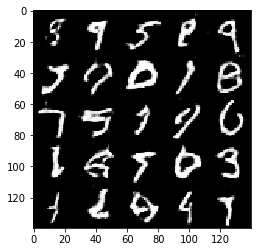

Epoch 2/2 - Batch 1510/1875:  Discriminator loss = 0.6747  Generator loss = 1.5358
Epoch 2/2 - Batch 1520/1875:  Discriminator loss = 0.6612  Generator loss = 1.7020
Epoch 2/2 - Batch 1530/1875:  Discriminator loss = 0.6281  Generator loss = 1.6924
Epoch 2/2 - Batch 1540/1875:  Discriminator loss = 0.7387  Generator loss = 1.5336
Epoch 2/2 - Batch 1550/1875:  Discriminator loss = 0.6325  Generator loss = 1.9714
Epoch 2/2 - Batch 1560/1875:  Discriminator loss = 0.5419  Generator loss = 2.1023
Epoch 2/2 - Batch 1570/1875:  Discriminator loss = 0.6262  Generator loss = 1.5733
Epoch 2/2 - Batch 1580/1875:  Discriminator loss = 0.9037  Generator loss = 1.0469
Epoch 2/2 - Batch 1590/1875:  Discriminator loss = 0.6423  Generator loss = 1.8526
Epoch 2/2 - Batch 1600/1875:  Discriminator loss = 0.5993  Generator loss = 1.9057


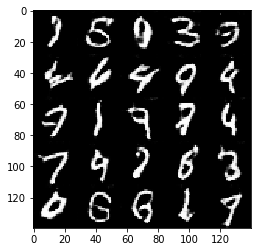

Epoch 2/2 - Batch 1610/1875:  Discriminator loss = 0.6591  Generator loss = 1.5398
Epoch 2/2 - Batch 1620/1875:  Discriminator loss = 0.6032  Generator loss = 1.7698
Epoch 2/2 - Batch 1630/1875:  Discriminator loss = 0.4811  Generator loss = 2.8138
Epoch 2/2 - Batch 1640/1875:  Discriminator loss = 0.5154  Generator loss = 2.0885
Epoch 2/2 - Batch 1650/1875:  Discriminator loss = 0.5781  Generator loss = 1.9067
Epoch 2/2 - Batch 1660/1875:  Discriminator loss = 0.6123  Generator loss = 2.5207
Epoch 2/2 - Batch 1670/1875:  Discriminator loss = 0.5546  Generator loss = 2.2895
Epoch 2/2 - Batch 1680/1875:  Discriminator loss = 0.5215  Generator loss = 2.6361
Epoch 2/2 - Batch 1690/1875:  Discriminator loss = 0.6045  Generator loss = 2.0158
Epoch 2/2 - Batch 1700/1875:  Discriminator loss = 0.7317  Generator loss = 1.3880


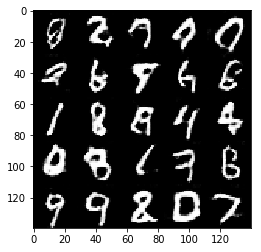

Epoch 2/2 - Batch 1710/1875:  Discriminator loss = 0.5348  Generator loss = 2.2735
Epoch 2/2 - Batch 1720/1875:  Discriminator loss = 0.6761  Generator loss = 1.5337
Epoch 2/2 - Batch 1730/1875:  Discriminator loss = 0.5362  Generator loss = 1.9199
Epoch 2/2 - Batch 1740/1875:  Discriminator loss = 0.5354  Generator loss = 2.0270
Epoch 2/2 - Batch 1750/1875:  Discriminator loss = 1.3210  Generator loss = 0.6193
Epoch 2/2 - Batch 1760/1875:  Discriminator loss = 0.5934  Generator loss = 2.0968
Epoch 2/2 - Batch 1770/1875:  Discriminator loss = 0.5593  Generator loss = 2.7071
Epoch 2/2 - Batch 1780/1875:  Discriminator loss = 0.5281  Generator loss = 2.4500
Epoch 2/2 - Batch 1790/1875:  Discriminator loss = 0.5332  Generator loss = 2.1098
Epoch 2/2 - Batch 1800/1875:  Discriminator loss = 0.4735  Generator loss = 2.4100


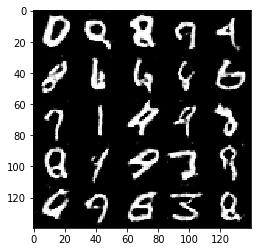

Epoch 2/2 - Batch 1810/1875:  Discriminator loss = 0.6407  Generator loss = 1.9691
Epoch 2/2 - Batch 1820/1875:  Discriminator loss = 0.7240  Generator loss = 1.2955
Epoch 2/2 - Batch 1830/1875:  Discriminator loss = 0.5732  Generator loss = 1.9026
Epoch 2/2 - Batch 1840/1875:  Discriminator loss = 0.4503  Generator loss = 2.6054
Epoch 2/2 - Batch 1850/1875:  Discriminator loss = 1.2724  Generator loss = 4.9031
Epoch 2/2 - Batch 1860/1875:  Discriminator loss = 0.6850  Generator loss = 1.5196
Epoch 2/2 - Batch 1870/1875:  Discriminator loss = 0.5886  Generator loss = 1.7397


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Finally here we will run the GANs on the CelebA dataset.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)